In [1]:
import pandas as pd
import seaborn as sn
import nearest_neighbors as nn
import cross_validation as cross_val
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from skimage.filters import gaussian
from skimage.transform import rotate
from scipy.ndimage import shift

In [2]:
mnist = fetch_openml('mnist_784')

In [3]:
X = mnist.data
y = mnist.target.astype(int)
X.shape, y.shape

((70000, 784), (70000,))

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, shuffle=True, random_state=42)

In [4]:
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y, test_size=3000,train_size=10000, shuffle=True, random_state=42)

## Задание №1

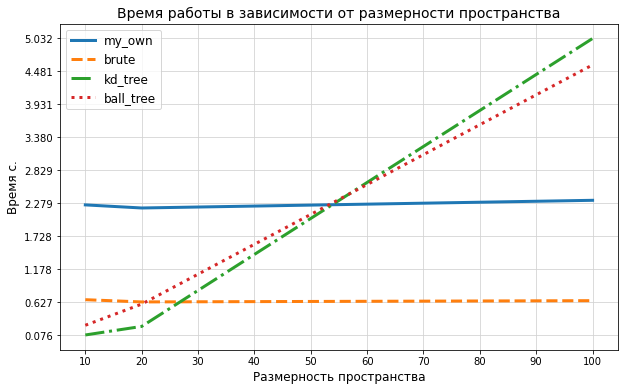

In [5]:
num_features = [10, 20, 100]
select_features = [np.random.choice(np.arange(784), i, replace=False) for i in num_features]

strategy = ["my_own", "brute", "kd_tree", "ball_tree"]
metric = "euclidean"

time = np.zeros((len(strategy), len(num_features)))

ls = ["-", "--", "-.", ":"]
fig = plt.figure(figsize=(10, 6))
for i, strat in enumerate(strategy):
    model = nn.KNNClassifier(5, strategy=strat, metric=metric)
    for j, f in enumerate(select_features):
        model.fit(X_train_t[:, f], y_train_t)
        t = %timeit -q -o model.find_kneighbors(X_test_t[:, f])
        time[i][j] = t.average
    plt.plot(num_features, time[i], label=strat, ls=ls[i], lw=3)
plt.ylabel("Время с.", size=12)
plt.xlabel("Размерность пространства", size=12)
plt.yticks(np.linspace(time.min(), time.max(), 10).round(4))
plt.xticks(np.arange(10, 101, 10))
plt.title("Время работы в зависимости от размерности пространства", size=14)
plt.grid(True, color="lightgrey")
plt.legend(fontsize=12)
fig.savefig("figures/task1.pdf")
plt.show()

## Задание №2/№3

eucliean, weight: False
cosine, weight: False
eucliean, weight: True
cosine, weight: True


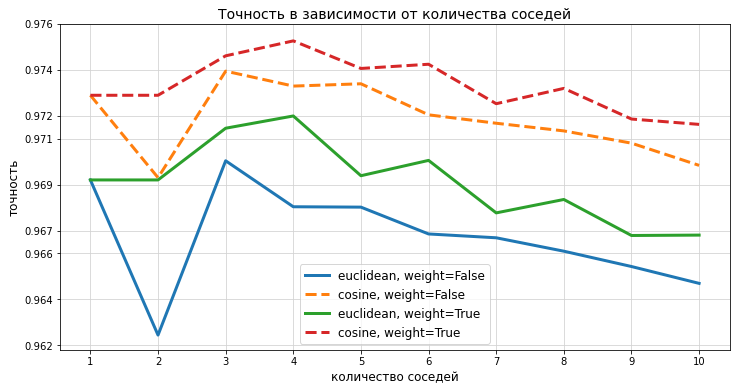

In [5]:
rg = np.arange(1, 11)
fig = plt.figure(figsize=(12, 6))

for w in [False, True]:
    str_w = "True" if w else "False"
    acc = cross_val.knn_cross_val_score(X_train, y_train, k_list=rg,
                                        cv=cross_val.kfold(X_train.shape[0], 3),
                                        strategy="brute", weights=w)
    plt.plot(rg, [sum(x[1])/len(x[1])for x in acc.items()],
             ls="-", label="euclidean, weight="+str_w, lw=3)
    print("eucliean, weight:", str_w)
    acc = cross_val.knn_cross_val_score(X_train, y_train, k_list=rg,
                                        cv=cross_val.kfold(X_train.shape[0], 3),
                                        metric="cosine", weights=w, test_block_size=700)
    plt.plot(rg, [sum(x[1])/len(x[1])for x in acc.items()],
             ls="--", label="cosine, weight="+str_w, lw=3)
    print("cosine, weight:", str_w)
plt.xticks(range(1, 11))
plt.yticks(np.linspace(0.962, 0.976, 9).round(3))
plt.xlabel("количество соседей", size = 12)
plt.ylabel("точность", size = 12)
plt.title("Точность в зависимости от количества соседей", size = 14)
plt.grid(True, color = "lightgrey")
plt.legend(fontsize = 12)
fig.savefig("figures/task2.pdf")
plt.show()

In [16]:
for s in [1000,2000,3000]:
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X, y,test_size=s, train_size=10000, shuffle=True, random_state=42)
    
    model_time_euc = nn.KNNClassifier(3, metric="euclidean", test_block_size=1000)
    model_time_cosine = nn.KNNClassifier(3, metric="cosine", test_block_size=1000)
    model_time_euc.fit(X_train_t, y_train_t)
    model_time_cosine.fit(X_train_t, y_train_t)

    time_euclidean = %timeit -q -o -n 5 model_time_euc.predict(X_test_t)
    time_cosine = %timeit -q -o -n 5 model_time_cosine.predict(X_test_t)
    print("test_size=1000: mean",time_euclidean.average, time_cosine.average)
    print("test_size=1000: std",time_euclidean.stdev, time_cosine.stdev)

test_size=1000: mean 0.9172622738571331 0.9001692547428061
test_size=1000: std 0.01500216407205933 0.0017747070576946784
test_size=1000: mean 1.7105870625142414 1.7960379396572015
test_size=1000: std 0.027539915835458645 0.11305334966202547
test_size=1000: mean 2.547899417200045 2.607969268057111
test_size=1000: std 0.02130801221371624 0.025673811627689124


## Задание №4

In [ ]:
best_model_base = nn.KNNClassifier(4, metric="cosine", weights=True, test_block_size=500)
best_model_base.fit(X_train, y_train)
y_pred_base = best_model_base.predict(X_test)
accuracy_score(y_test, y_pred_base)

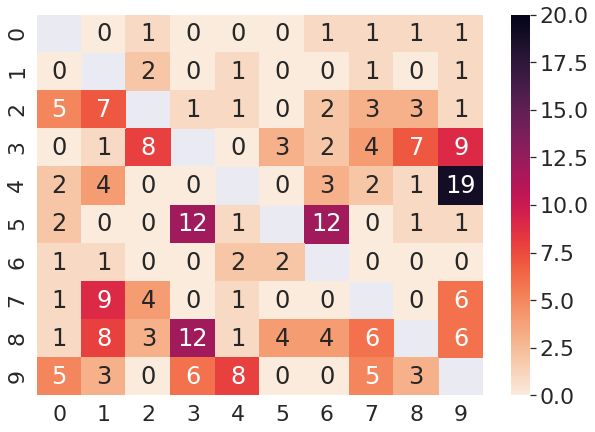

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_base, labels=range(10))
df_cm = pd.DataFrame(cm, range(10), range(10))
for i in range(10):
    df_cm.iloc[i,i]=float("inf")
    
fig = plt.figure(figsize=(10, 7))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap="rocket_r",vmax=20)
fig.savefig("figures/task4.pdf")
plt.show()

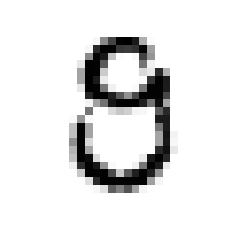

In [41]:
lim = 1
for i in range(10):
    for j in range(10):
        if(i == j):
            continue
        ind = np.where((y_test == i) & (y_pred_base == j))[0]
        if(ind.size >= lim):
            #fig, ax = plt.subplots(1, ind.size, figsize=(10, 2))
            #print("true:", i, "predict:", j, "num of wrong:", ind.size)
            for k, index in enumerate(ind):
                #print(index, end="  ")
                plt.imshow(X_test[index].reshape(28, 28), cmap="Greys")
                plt.axis("off")
                plt.savefig("figures/wrong_base/digit_"+str(i)+"_"+str(j)+"_"+str(index)+".pdf")
            #plt.show()

## Задание №5

In [6]:
def augmentation(X, param):
    if param.get("gauss", None) is not None:
        tmp = np.apply_along_axis(lambda x: gaussian(x.reshape(28, 28), sigma=param["gauss"]).ravel(), 1, X)
    if param.get("rotate", None) is not None:
        tmp = np.apply_along_axis(lambda x: rotate(x.reshape(28, 28), angle=param["rotate"]).ravel(), 1, X)
    if param.get("shift_x", None) is not None:
        tmp = np.apply_along_axis(lambda x: shift(x.reshape(28, 28), shift=(0, param["shift_x"])).ravel(), 1, X)
    if param.get("shift_y", None) is not None:
        tmp = np.apply_along_axis(lambda x: shift(x.reshape(28, 28), shift=(param["shift_y"], 0)).ravel(), 1, X)
    return tmp

In [12]:
def knn_cross_val_score_modified(X, y, k_list, param, cv=None, score="accuracy", **kwargs):
    if cv is None:
        cv = kfold(X.shape[0], 2)
    model = nn.KNNClassifier(k_list[-1], **kwargs)

    k_neigh = {}
    for train, test in cv:

        tmp_aug = augmentation(X[train], param)
        X_train_aug = np.vstack((X[train], tmp_aug))
        y_train_aug = np.hstack((y[train], y[train]))

        del tmp_aug
        model.fit(X_train_aug, y_train_aug)

        if kwargs.get("weights", False):
            mat_pairwise, mat_indexs = model.find_kneighbors(X[test])
            mat_weights = 1/(mat_pairwise+10e-5)
        else:
            mat_indexs = model.find_kneighbors(X[test], return_distance=False)

        labels = np.apply_along_axis(lambda x: y_train_aug[x], arr=mat_indexs, axis=1)
        del mat_indexs
        
        for k in k_list:
            if k_neigh.get(k, None) is None:
                k_neigh[k] = []

            uniq_y = np.unique(y_train_aug)
            tmp = (labels[:, :k, np.newaxis] == uniq_y.reshape(1, 1, -1))

            if kwargs.get("weights", False):
                tmp = tmp*mat_weights[:, :k, np.newaxis]

            predict = uniq_y[tmp.sum(axis=1).argmax(axis=1)]
            k_neigh[k].append(accuracy_score(predict, y[test]))

    return k_neigh

In [14]:
params = {"rotate": [-15, -10, -5, 0, 5, 10, 15],
          "shift_x": [-3, -2, -1, 1, 2, 3],
          "shift_y": [-3, -2, -1, 1, 2, 3],
          "gauss": [0.5, 1, 1.5]}
score = {}

ind = np.random.choice(np.arange(X_train.shape[0]), 10000, replace=False)
X_train_aug = X_train[ind]
y_train_aug = y_train[ind]
cv_aug = cross_val.kfold(X_train_aug.shape[0], 3)

print("best: 0.9771")
for param in params:
    score[param] = []
    for value in params[param]:

        acc_aug = knn_cross_val_score_modified(X_train_aug, y_train_aug, k_list=[4], param={param: value},
                                               cv=cv_aug, metric="cosine", weights=True, test_block_size=700)
        acc_aug = np.array(acc_aug[4])
        score[param].append(acc_aug.mean())
        print(param, value, acc_aug.mean())
        
# Я дурак и не сохранил результаты эксперимента, который в отчете остался. Я его делал
# На выборке гораздо большего размера, так что ему можно доверять сильнее, чем 
# этому эксперименту

best: 0.9771
rotate -15 0.9560995691650748
rotate -10 0.9581998691770797
rotate -5 0.9575999891530844
rotate 0 0.9508000290130992
rotate 5 0.9594998492050765
rotate 10 0.9617998392520716
rotate 15 0.959899829215075
shift_x -3 0.9560997191500794
shift_x -2 0.9561996691570777
shift_x -1 0.9563000391220885
shift_x 1 0.9590997492070743
shift_x 2 0.9580999191700813
shift_x 3 0.9565997991520807
shift_y -3 0.9556997691370817
shift_y -2 0.9576996391900737
shift_y -1 0.9580996491970732
shift_y 1 0.9580998291790787
shift_y 2 0.9564999691330861
shift_y 3 0.9562997091550787
gauss 0.5 0.9564997591540797
gauss 1 0.9641999292910693
gauss 1.5 0.963299719294065


In [7]:
best_model_base = nn.KNNClassifier(4, metric="cosine", weights=True, test_block_size=1000)
best_model_base.fit(X_train, y_train)
y_pred_base = best_model_base.predict(X_test)
accuracy_score(y_test, y_pred_base)

0.9771

In [8]:
X_gauss = augmentation(X_train, {"gauss": 1})
X_rotate = augmentation(X_train, {"rotate": -10})

X_train_aug = np.vstack((X_train, X_gauss, X_rotate))
y_train_aug = np.hstack((y_train, y_train, y_train))

best_model_aug = nn.KNNClassifier(4, metric="cosine", weights=True, test_block_size=200)
best_model_aug.fit(X_train_aug, y_train_aug)
y_pred_aug = best_model_aug.predict(X_test)
print(accuracy_score(y_test, y_pred_aug))

0.9834


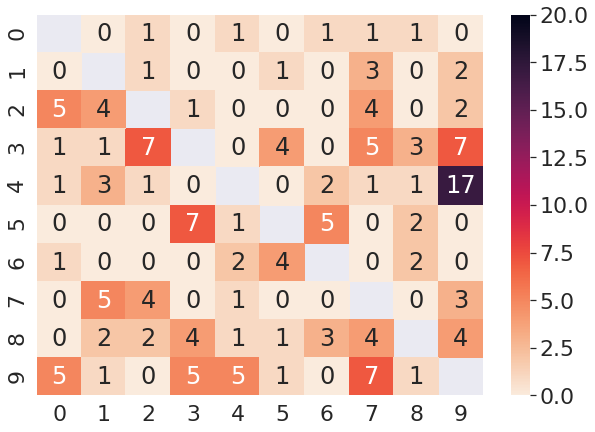

In [18]:
from sklearn.metrics import confusion_matrix

cm_base = confusion_matrix(y_test, y_pred_base, labels=range(10))
df_base = pd.DataFrame(cm_base, range(10), range(10))

for i in range(10):
    df_base.iloc[i,i]=float("inf")
    
cm_aug = confusion_matrix(y_test, y_pred_aug, labels=range(10))
df_aug = pd.DataFrame(cm_aug, range(10), range(10))

for i in range(10):
    df_aug.iloc[i,i]=float("inf")
    
#fig, ax = plt.subplots(2, 2, figsize=(16, 10))
#sn_0_0 = sn.heatmap(df_base, annot=True, cmap="rocket_r", ax=ax[0, 0], vmax=20)
    
fig = plt.figure(figsize=(10, 7))
sn.set(font_scale=2)
sn_0_1 = sn.heatmap(df_aug, annot=True, cmap="rocket_r", vmax=20)
fig.savefig("figures/task5_conf_mat.pdf")
#sn_1_0 = sn.heatmap(df_base-df_aug, annot=True, cmap="rocket_r", ax=ax[1, 0])
#sn_1_1 = sn.heatmap(-df_base+df_aug, annot=True, cmap="rocket_r", ax=ax[1, 1])
plt.show()

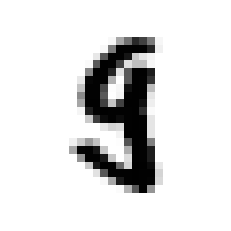

In [19]:
lim = 1
for i in range(10):
    for j in range(10):
        if(i == j):
            continue
        ind = np.where((y_test == i) & (y_pred_base == j)&(y_pred_aug == i))[0]
        if(ind.size >= lim):
            #fig, ax = plt.subplots(1, ind.size, figsize=(10, 2))
            #print("true:", i, "predict:", j, "num of wrong:", ind.size)
            for k, index in enumerate(ind):
                #print(index, end="  ")
                plt.imshow(X_test[index].reshape(28, 28), cmap="Greys")
                plt.axis("off")
                plt.savefig("figures/wrong_base_vs_aug/digit_"+str(i)+"_"+str(j)+"_"+str(index)+".pdf")
            #plt.show()

## Задание №6

In [18]:
def knn_cross_val_score_modified_6(X, y, k_list, param, cv=None, score="accuracy", **kwargs):
    if cv is None:
        cv = kfold(X.shape[0], 2)
    model = nn.KNNClassifier(k_list[-1], **kwargs)

    k_neigh = {}
    for train, test in cv:
        model.fit(X[train], y[train])

        X_test = augmentation(X[test], param)

        mat_p_basic, mat_i_basic = model.find_kneighbors(X[test])
        mat_p_aug, mat_i_aug = model.find_kneighbors(X_test)

        mat_pairwise = np.hstack((mat_p_aug, mat_p_basic))
        mat_indexs = np.hstack((mat_i_aug, mat_i_basic))
        
        del mat_p_basic
        del mat_i_basic
        del mat_p_aug
        del mat_i_aug
        arg_sort = np.argsort(mat_pairwise, axis=1)
        mat_pairwise = np.take_along_axis(mat_pairwise, arg_sort, axis=1)[:, :k_list[-1]]
        mat_indexs = np.take_along_axis(mat_indexs, arg_sort, axis=1)[:, :k_list[-1]]
        
        mat_weights = 1/(mat_pairwise+10e-5)
        del mat_pairwise

        labels = np.apply_along_axis(lambda x: y[train][x], arr=mat_indexs, axis=1)
        for k in k_list:
            if k_neigh.get(k, None) is None:
                k_neigh[k] = []

            uniq_y = np.unique(y[train])
            tmp = (labels[:, :k, np.newaxis] == uniq_y.reshape(1, 1, -1))

            tmp = tmp*mat_weights[:, :k, np.newaxis]
            
            predict = uniq_y[tmp.sum(axis=1).argmax(axis=1)]
            
            k_neigh[k].append(accuracy_score(predict, y[test]))

    return k_neigh

In [19]:
params = {"rotate": [-15, -10, -5, 0, 5, 10, 15],
          "shift_x": [-3, -2, -1, 1, 2, 3],
          "shift_y": [-3, -2, -1, 1, 2, 3],
          "gauss": [0.5, 1, 1.5]}

score_6 = {}

ind = np.random.choice(np.arange(X_train.shape[0]), 25000, replace=False)
X_train_aug = X_train[ind]
y_train_aug = y_train[ind]
cv_aug = cross_val.kfold(X_train_aug.shape[0], 3)

for param in params:
    score_6[param] = []
    for value in params[param]:

        acc_aug = knn_cross_val_score_modified_6(X_train_aug, y_train_aug, k_list=[4], param={param: value},
                                                 cv=cv_aug, metric="cosine", weights=True, test_block_size=700)
        acc_aug = np.array(acc_aug[4])
        score_6[param].append(acc_aug.mean())
        print(param, value, acc_aug.mean())

rotate -15 0.9663201022881328
rotate -10 0.9667601102892207
rotate -5 0.9660001086868529
rotate 0 0.9642001038812852
rotate 5 0.9674400414941484
rotate 10 0.9658000766874927
rotate 15 0.9624801646733495
shift_x -3 0.9662801582857652
shift_x -2 0.967400159889285
shift_x -1 0.9690801262960046
shift_x 1 0.9672001758880051
shift_x 2 0.9663201742852531
shift_x 3 0.9662801870846133
shift_y -3 0.9670001870869172
shift_y -2 0.967240172688261
shift_y -1 0.9692801246967085
shift_y 1 0.9684000702960683
shift_y 2 0.966480175885701
shift_y 3 0.9663201838848692
gauss 0.5 0.9665600830896687
gauss 1 0.9529601342441026
gauss 1.5 0.914080249315084


In [10]:
params = {"rotate": [-15, -10, -5, 0, 5, 10, 15],
          "shift_x": [-3, -2, -1, 1, 2, 3],
          "shift_y": [-3, -2, -1, 1, 2, 3],
          "gauss": [0.5, 1, 1.5]}

k = 4
model = nn.KNNClassifier(k, weights=True, metric="cosine", test_block_size=200)
model.fit(X_train, y_train)

X_test_aug1 = augmentation(X_test, {"shift_y": -1})
X_test_aug2 = augmentation(X_test, {"shift_x": -1})

mat_p_basic, mat_i_basic = model.find_kneighbors(X_test)
mat_p_aug1, mat_i_aug1 = model.find_kneighbors(X_test_aug1)
mat_p_aug2, mat_i_aug2 = model.find_kneighbors(X_test_aug2)

mat_pairwise = np.hstack((mat_p_aug1, mat_p_aug2, mat_p_basic))
mat_indexs = np.hstack((mat_i_aug1, mat_i_aug2, mat_i_basic))

del mat_p_basic
del mat_i_basic
del mat_p_aug1
del mat_i_aug1
del mat_p_aug2
del mat_i_aug2

arg_sort = np.argsort(mat_pairwise, axis=1)
mat_pairwise = np.take_along_axis(mat_pairwise, arg_sort, axis=1)[:, :k]
mat_indexs = np.take_along_axis(mat_indexs, arg_sort, axis=1)[:, :k]

mat_weights = 1/(mat_pairwise+10e-5)
del mat_pairwise

labels = np.apply_along_axis(lambda x: y_train[x], arr=mat_indexs, axis=1)

uniq_y = np.unique(y_train)
tmp = (labels[:, :k, np.newaxis] == uniq_y.reshape(1, 1, -1))

tmp = tmp*mat_weights[:, :k, np.newaxis]

predict = uniq_y[tmp.sum(axis=1).argmax(axis=1)]
accuracy_score(predict, y_test)

0.98

In [ ]:
lim = 1
for i in range(10):
    for j in range(10):
        if(i == j):
            continue
        ind = np.where((y_test == i) & (y_pred_base == j) & (predict == i))[0]
        if(ind.size >= lim):
            #fig, ax = plt.subplots(1, ind.size, figsize=(10, 2))
            #print("true:", i, "predict:", j, "num of wrong:", ind.size)
            for k, index in enumerate(ind):
                #print(index, end="  ")
                plt.imshow(X_test[index].reshape(28, 28), cmap="Greys")
                plt.axis("off")
                plt.savefig("figures/wrong_base_vs_aug_6/digit_"+str(i)+"_"+str(j)+"_"+str(index)+".pdf")
            #plt.show()

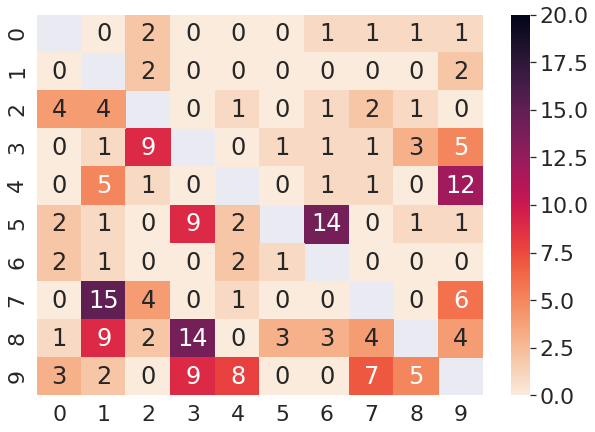

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predict, labels=range(10))
df_cm = pd.DataFrame(cm, range(10), range(10))
for i in range(10):
    df_cm.iloc[i,i]=float("inf")
    
fig = plt.figure(figsize=(10, 7))
sn.set(font_scale=2)
sn.heatmap(df_cm, annot=True, cmap="rocket_r",vmax=20)
fig.savefig("figures/task6.pdf")
plt.show()

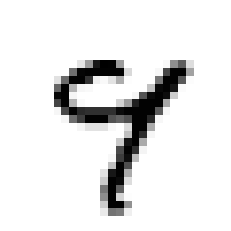

In [12]:
lim = 1
for i in range(10):
    for j in range(10):
        if(i == j):
            continue
        ind = np.where((y_test == i) & (y_pred_aug == j) & (predict == i))[0]
        if(ind.size >= lim):
            #fig, ax = plt.subplots(1, ind.size, figsize=(10, 2))
            #print("true:", i, "predict:", j, "num of wrong:", ind.size)
            for k, index in enumerate(ind):
                #print(index, end="  ")
                plt.imshow(X_test[index].reshape(28, 28), cmap="Greys")
                plt.axis("off")
                plt.savefig("figures/wrong_5_vs_6/digit_"+str(i)+"_"+str(j)+"_"+str(index)+".pdf")
            #plt.show()

In [14]:
k = 4

X_gauss = augmentation(X_train, {"gauss": 1})
X_rotate = augmentation(X_train, {"rotate": -10})

X_train_aug = np.vstack((X_train, X_gauss, X_rotate))
y_train_aug = np.hstack((y_train, y_train, y_train))

print("pred_model")

model = nn.KNNClassifier(k, weights=True, metric="cosine", test_block_size=100)
model.fit(X_train_aug, y_train_aug)

X_test_aug1 = augmentation(X_test, {"shift_y": -1})
X_test_aug2 = augmentation(X_test, {"shift_x": -1})

print("pred find")

mat_p_basic, mat_i_basic = model.find_kneighbors(X_test)
mat_p_aug1, mat_i_aug1 = model.find_kneighbors(X_test_aug1)
mat_p_aug2, mat_i_aug2 = model.find_kneighbors(X_test_aug2)

mat_pairwise = np.hstack((mat_p_aug1, mat_p_aug2, mat_p_basic))
mat_indexs = np.hstack((mat_i_aug1, mat_i_aug2, mat_i_basic))

del mat_p_basic
del mat_i_basic
del mat_p_aug1
del mat_i_aug1
del mat_p_aug2
del mat_i_aug2

arg_sort = np.argsort(mat_pairwise, axis=1)
mat_pairwise = np.take_along_axis(mat_pairwise, arg_sort, axis=1)[:, :k]
mat_indexs = np.take_along_axis(mat_indexs, arg_sort, axis=1)[:, :k]

mat_weights = 1/(mat_pairwise+10e-5)
del mat_pairwise

labels = np.apply_along_axis(lambda x: y_train_aug[x], arr=mat_indexs, axis=1)

uniq_y = np.unique(y_train)
tmp = (labels[:, :k, np.newaxis] == uniq_y.reshape(1, 1, -1))

tmp = tmp*mat_weights[:, :k, np.newaxis]

predict = uniq_y[tmp.sum(axis=1).argmax(axis=1)]
accuracy_score(predict, y_test)

0.9833